# Weather forecast in Germany

This notebook was adopted from [Hvass-Labs][1]'s tensorflow tutorial.

[1]: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

In this notebook, we will try to predict weather for near future. For testing, I am going to use weather data collected for the city Wiesbaden, as I live here now.

The data is collected from [Climate Data Center (CDC)][2] of Deutscher Wetterdienst.

[2]: https://cdc.dwd.de/portal/201804271017/index.html

Data can be downloaded from this [ftp server][3].

[3]: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/


Check out this [PDF][4] for dataset description.

[4]: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/DESCRIPTION_obsgermany_climate_hourly_tu_historical_en.pdf

### Import Modules

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

### Define the Paths

In [3]:
ROOT_DIR = '/Users/sparrow/Learning/machine-learning/aparecium/german-weather-forecast'
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
DATASET_DIR = '/srv/downloads/moshfiqur-ml-datasets/aparecium/german-weather-forecast'

### Load Data

The weather information data is distributed by station. The list of stations and other related data can be found here: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/TU_Stundenwerte_Beschreibung_Stationen.txt

The station ID for Wiesbaden is 05541. So, I downloaded the data for wiesbaden:
ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/stundenwerte_TU_05541_20040801_20171231_hist.zip


In [4]:
station_id = '05541'
date_from = 20040801
date_to = 20171231
total_data_rows = 263
station_lat = 50.1320
station_lon = 8.3170
station_name = 'Wiesbaden-Auringen'
station_state = 'Hessen'

data_folder = 'stundenwerte_TU_{}_{}_{}_hist'.format(station_id, date_from, date_to)
data_file = 'produkt_tu_stunde_{}_{}_{}.txt'.format(date_from, date_to, station_id)


In [5]:
df = pd.read_csv(os.path.join(DATASET_DIR, data_folder, data_file), delimiter=';')
df.head()

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
0,5541,2004080100,3,19.3,71.0,eor
1,5541,2004080101,10,18.5,75.0,eor
2,5541,2004080102,10,17.8,78.0,eor
3,5541,2004080103,10,17.8,78.0,eor
4,5541,2004080104,10,17.7,78.0,eor


### Data Cleanup

Data info:
```
STATIONS_ID = Station ID
MESS_DATUM = Messurement time, in yyyymmddhh format
QN_9 = Quality level of next columns
TT_TU = 2m air temperature, in degree celcius
RF_TU = 2m relative humidity, in %
eor = End of record
```

#### Convert MESS_DATUM to DateTiime format and save to a column

In [6]:
df['DATE_TIME'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')
# df.sort_values(['DATE_TIME'])
df.tail()

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor,DATE_TIME
117401,5541,2017123119,3,9.1,82.0,eor,2017-12-31 19:00:00
117402,5541,2017123120,3,9.4,80.0,eor,2017-12-31 20:00:00
117403,5541,2017123121,3,9.3,79.0,eor,2017-12-31 21:00:00
117404,5541,2017123122,3,9.1,79.0,eor,2017-12-31 22:00:00
117405,5541,2017123123,3,9.9,77.0,eor,2017-12-31 23:00:00


#### Set the DATE_TIME as index

In [7]:
df.set_index('DATE_TIME', inplace=True)
df.tail()

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
DATE_TIME,,,,,,
2017-12-31 19:00:00,5541,2017123119,3,9.1,82.0,eor
2017-12-31 20:00:00,5541,2017123120,3,9.4,80.0,eor
2017-12-31 21:00:00,5541,2017123121,3,9.3,79.0,eor
2017-12-31 22:00:00,5541,2017123122,3,9.1,79.0,eor
2017-12-31 23:00:00,5541,2017123123,3,9.9,77.0,eor


#### Drop unnecessary columns

In [8]:

df.drop(['MESS_DATUM', 'STATIONS_ID', 'QN_9', 'eor'], inplace=True, axis=1)

#### Plot the temperature data 
There are some error in the data. As we see below, there are two data instance where temperature went almost to -1000 degree celcius which is impossible.

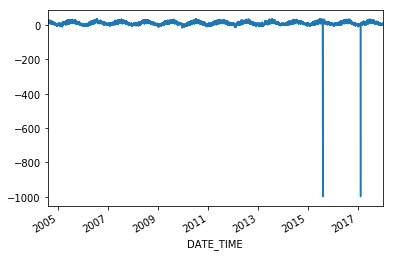

In [9]:
df['TT_TU'].plot()

#### Plot the humidity data
There are some errors in humidity data as well as there are 3 instances of data which contains negative value for humidity which is not possible

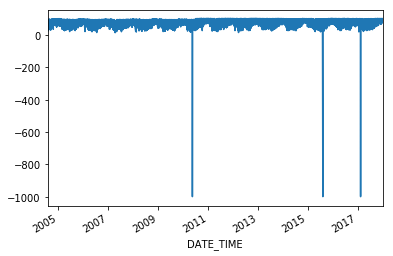

In [10]:
df['RF_TU'].plot()

#### Overview of the problematic data

In [11]:
df.loc[(df['RF_TU'] < -50) | (df['TT_TU'] < -50)].head()

,TT_TU,RF_TU
DATE_TIME,,
2010-05-20 04:00:00,8.1,-999.0
2015-08-11 13:00:00,-999.0,-999.0
2017-02-12 13:00:00,-999.0,-999.0
2017-02-12 14:00:00,-999.0,-999.0
2017-02-12 15:00:00,-999.0,-999.0


#### Perform LOCF (Last Observation Carried Forward) to fix bad data

In [12]:
# First replace the bad data with NaN
df.loc[df['RF_TU'] < -50, 'RF_TU'] = np.NaN
df.loc[df['TT_TU'] < -50, 'TT_TU'] = np.NaN

# Then perform a forward fill
df.fillna(method='ffill', inplace=True)

#### Plot data after fixing

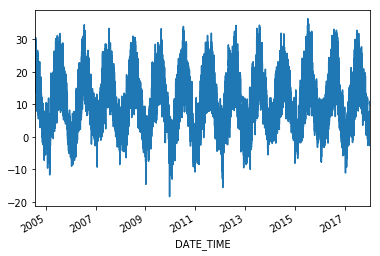

In [13]:
df['TT_TU'].plot()

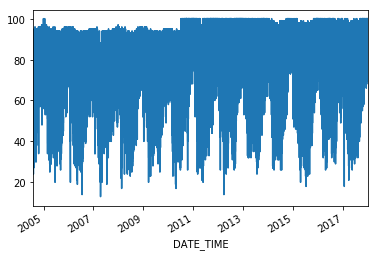

In [14]:
df['RF_TU'].plot()

### Data Preparation

The dataset has observation for each hour, so there are 24 observations in a day. We want to predict the weather 24 hours in the future. So, we shift the data 24 times in the future. For one week, the shift steps would be 7 * 24. 

In [15]:
shift_days = 1
shift_steps = shift_days * 24

Create a new dataframe with the time shifted data. To shift the data in future direction, we must shift it with negative direction. 

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. You can check the time-shift is correct by comparing the original and time-shifted dataframes.

In [16]:
df_shifted = df[['TT_TU', 'RF_TU']].shift(-shift_steps)

The first `shift_steps + 5` rows of the original dataframe 

In [17]:
df.head(shift_steps + 5)

,TT_TU,RF_TU
DATE_TIME,,
2004-08-01 00:00:00,19.3,71.0
2004-08-01 01:00:00,18.5,75.0
2004-08-01 02:00:00,17.8,78.0
2004-08-01 03:00:00,17.8,78.0
2004-08-01 04:00:00,17.7,78.0
2004-08-01 05:00:00,17.6,80.0
2004-08-01 06:00:00,18.8,74.0
2004-08-01 07:00:00,20.6,68.0
2004-08-01 08:00:00,22.5,58.0


In [18]:
df.tail(5)

,TT_TU,RF_TU
DATE_TIME,,
2017-12-31 19:00:00,9.1,82.0
2017-12-31 20:00:00,9.4,80.0
2017-12-31 21:00:00,9.3,79.0
2017-12-31 22:00:00,9.1,79.0
2017-12-31 23:00:00,9.9,77.0


The following is the first 5 rows of the time shifted dataframe. This should be identical to the last 5 rows shown above from the original data, except for the timestamp.

In [19]:
df_shifted.head(5)

,TT_TU,RF_TU
DATE_TIME,,
2004-08-01 00:00:00,17.7,69.0
2004-08-01 01:00:00,17.4,71.0
2004-08-01 02:00:00,16.4,72.0
2004-08-01 03:00:00,16.9,70.0
2004-08-01 04:00:00,16.5,73.0


The time shifted dataframe has the same length as the original dataframe, except the last `shift_steps` rows has Nan. Because we shifted the data backwards, hence those rows does not contain any data.

In [20]:
df_shifted.tail()

,TT_TU,RF_TU
DATE_TIME,,
2017-12-31 19:00:00,NaN,NaN
2017-12-31 20:00:00,NaN,NaN
2017-12-31 21:00:00,NaN,NaN
2017-12-31 22:00:00,NaN,NaN
2017-12-31 23:00:00,NaN,NaN


We will now convert the pandas dataframe into numpy arrays so that it can be input into the neural network. We will not consider the last `shift_steps` number of rows in the original dataframe. Because, in the shifted dataframe, those rows contains NaN. Those NaN will produce errors as they are not valid data. Also, we need to have same shape for input and output data.

In [21]:
df.shape, df_shifted.shape

((117406, 2), (117406, 2))

In [22]:
target_names = ['TT_TU', 'RF_TU']

# Training data
data_train = df.values[0:-shift_steps]

# Testing data
data_target = df_shifted.values[0:-shift_steps]

data_train.shape, data_target.shape

((117382, 2), (117382, 2))

In [23]:
df.values.shape, shift_steps, type(df.values)

((117406, 2), 24, numpy.ndarray)

In [24]:
# Number of observations
num_data = len(data_train)

# Percentage of dataset that will be used for training
train_split = 0.8

# Number of observations in the training set
num_train = int(train_split * num_data)

# Number of observation in the test set
num_test = num_data - num_train

# Samples for train and test dataset
X_train = data_train[0:num_train]
X_test = data_train[num_train:]

y_train = data_target[0:num_train]
y_test = data_target[num_train:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((93905, 2), (93905, 2), (23477, 2), (23477, 2))

In [25]:
# number of input values
# 2, one for temperature and 
# another for humidity
# TODO should be input_shape
input_shape = X_train.shape[1]

# number of output values
# 2, one for temperature and 
# another for humidity
# TODO should be output_shape
output_shape = y_train.shape[1]

input_shape, output_shape

(2, 2)

### Data Normalization

In [26]:
print('Min:', np.min(X_train))
print('Max:', np.max(X_train))

Min: -18.5
Max: 100.0


As we can see from above, the dataset contains a wide range of values. Neural network works best on values ranges between -1 to 1. So, we need to scale the data before it is being input to the neural network.

In [27]:
x_scaler = MinMaxScaler()

# Detect the range of values from the training dataset
# and scale the training data.
X_train_scaled = x_scaler.fit_transform(X_train)

# Use the same scaler to scale the test dataset
X_test_scaled = x_scaler.transform(X_test)

In [28]:
print('Min Train:', np.min(X_train_scaled))
print('Max Train:', np.max(X_train_scaled))
print('Min Test:', np.min(X_test_scaled))
print('Max Test:', np.max(X_test_scaled))

Min Train: 0.0
Max Train: 1.0
Min Test: 0.057471264367816105
Max Test: 1.0358490566037735


The test data comes from the same dataset except we just shifted it. So, we can use the same scaler to scale the target dataset as we expect that there won't be any huge difference in the data ranges.

In [29]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [30]:
print('Min:', np.min(y_train_scaled))
print('Max:', np.max(y_train_scaled))

Min: 0.0
Max: 1.0


### Data Generator

Lets have a look at the final dataset shapes

In [31]:
print('X_train_scaled:', X_train_scaled.shape)
print('y_train_scaled:', y_train_scaled.shape)
print('X_test_scaled:', X_test_scaled.shape)
print('y_test_scaled:', y_test_scaled.shape)

X_train_scaled: (93905, 2)
y_train_scaled: (93905, 2)
X_test_scaled: (23477, 2)
y_test_scaled: (23477, 2)


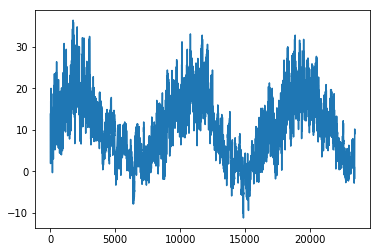

In [32]:
plt.plot(X_test[:, 0])

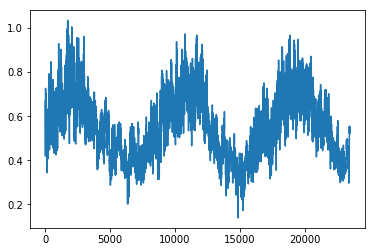

In [33]:
plt.plot(y_test_scaled[:, 0])

Instead of training the RNN on the complete dataset, we will train it on smaller batch of data.

In [34]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        X_shape = (batch_size, sequence_length, input_shape)
        X_batch = np.zeros(shape=X_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, output_shape)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            X_batch[i] = X_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (X_batch, y_batch)

We will train the RNN with 1 week of data at a time, hence the sequence length is 168 = 24 * 7

In [35]:
batch_size = 32
sequence_length = 24 * 7

In [36]:
# Create the batch generator
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [37]:
# Lets see if the batch generator works
X_batch, y_batch = next(generator)

print(X_batch.shape)
print(y_batch.shape)

(32, 168, 2)
(32, 168, 2)


Lets have a look at one sample data from `X_batch` and `y_batch`

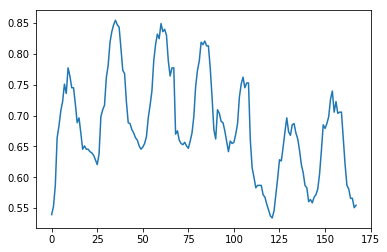

In [38]:
plt.plot(X_batch[0, :, 0])

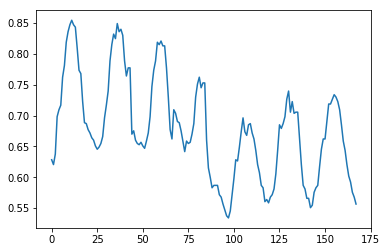

In [39]:
plt.plot(y_batch[0, :, 0])

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [40]:
validation_data = (np.expand_dims(X_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

### Creating the RNN

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity.

In [41]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by None), where each observation has a number of input-signals (input_shape).

In [42]:
model.add(GRU(units=512, return_sequences=True, input_shape=(None, input_shape,)))

The GRU outputs a batch of sequences of 512 values. We want to predict 2 output values, so we add a fully-connected (or dense) layer which maps 512 values down to only 2 values.

The output values in the dataset have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [43]:
model.add(Dense(output_shape, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid NaN values during training. You may need to experiment with this to get it working.

In [44]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(output_shape,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [45]:
warmup_steps = 50

In [46]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, output_shape].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, output_shape

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

In [47]:
# This is the optimizer and the beginning learning-rate that we will use.
optimizer = RMSprop(lr=1e-3)

In [48]:
# We then compile the Keras model so it is ready for training.
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

This is a very small model with only two layers. The output shape of (None, None, 2) means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 2 outputs. This corresponds to the 2 target outputs we want to predict.

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         791040    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 792,066
Trainable params: 792,066
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [50]:
path_checkpoint = 'checkpoint_3.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [51]:
# This is the callback for stopping the optimization when performance worsens on the validation-set.
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [52]:
# This is the callback for writing the TensorBoard log during training.
callback_tensorboard = TensorBoard(log_dir='logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by patience=0). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [53]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [54]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [55]:
# The main training process, when need to train a new 
# model, change if condition to True
if True:
    %%time
    model.fit_generator(generator=generator,
                        epochs=20,
                        steps_per_epoch=100,
                        validation_data=validation_data,
                        callbacks=callbacks)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 1/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0174
Epoch 00001: val_loss improved from inf to 0.01320, saving model to checkpoint_3.keras
100/100 [==============================] - 138s 1s/step - loss: 0.0174 - val_loss: 0.0132
Epoch 2/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0132
Epoch 00002: val_loss did not improve from 0.01320

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 129s 1s/step - loss: 0.0132 - val_loss: 0.0141
Epoch 3/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0114
Epoch 00003: val_loss improved from 0.01320 to 0.01174, saving model to checkpoint_3.keras
100/100 [==============================] - 124s 1s/step - loss: 0.0114 - val_loss: 0.0117
Epoch 4/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0109
Epoch 00004: val_loss improved from 0.01174

In [56]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [57]:
result = model.evaluate(x=np.expand_dims(X_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 13s 13s/step


In [58]:
print("loss (test-set):", result)

loss (test-set): 0.010320659726858139


In [59]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [60]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = X_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(output_shape):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

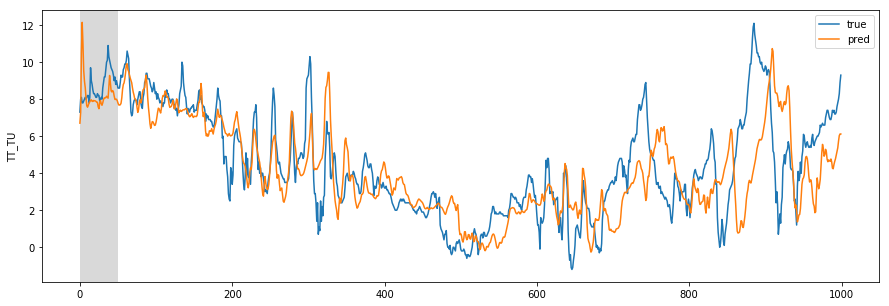

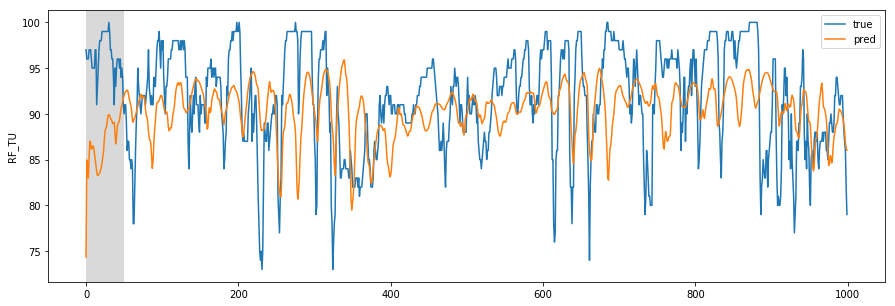

In [61]:
plot_comparison(start_idx=90000, length=1000, train=True)

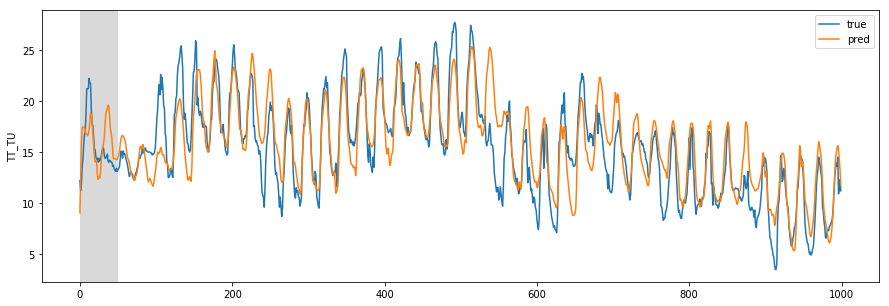

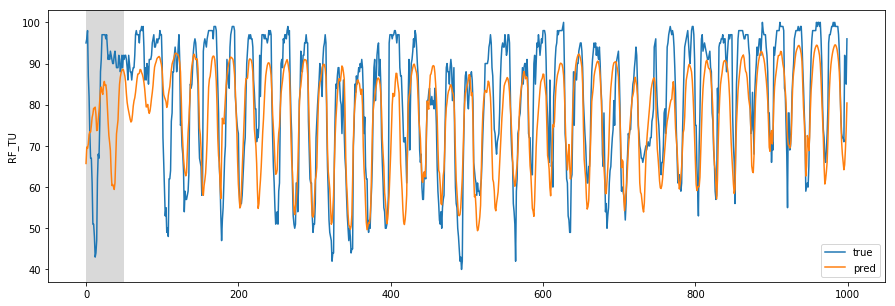

In [62]:
plot_comparison(start_idx=20000, length=1000, train=False)

From the graphs above, we can see that prediction is much more better on test set than training set.